In [19]:
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.restoration import denoise_nl_means, estimate_sigma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import PowerNorm


*數據讀取函數*

In [20]:
# 數據讀取函數
def read_data(file_path):
    data = np.loadtxt(file_path)
    return data

# 基本繪圖函數 (不含地理信息和網格)
def plot_image(image, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.colorbar(label='Value')
    plt.show()

# 改進的繪圖函數，並排顯示原始和處理後的圖像
def plot_comparison(original, processed, title, sigma_est):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    im1 = ax1.imshow(original, cmap='gray')
    ax1.set_title('Original Image')
    fig.colorbar(im1, ax=ax1, label='Value')
    
    im2 = ax2.imshow(processed, cmap='gray')
    ax2.set_title(f'After {title} (Estimated σ: {sigma_est:.2f})')
    fig.colorbar(im2, ax=ax2, label='Value')
    
    plt.suptitle(title, fontsize=16)
    plt.show()

評估指標函數

In [21]:
def calculate_enl(image, window_size=10):
    h, w = image.shape
    n_windows = (h // window_size) * (w // window_size)
    enl_values = []
    
    for i in range(0, h - window_size, window_size):
        for j in range(0, w - window_size, window_size):
            window = image[i:i+window_size, j:j+window_size]
            mean = np.mean(window)
            var = np.var(window)
            if var != 0:
                enl_values.append((mean ** 2) / var)
    
    return np.mean(enl_values)

def calculate_var(image):
    return np.var(image)

def calculate_bds(image):
    threshold = np.mean(image)
    bright = image[image > threshold]
    dark = image[image <= threshold]
    return np.mean(bright) - np.mean(dark)

def calculate_relative_backscatter(image):
    mean = np.mean(image)
    return np.std(image) / mean

def calculate_weighted_relative_backscatter(image):
    mean = np.mean(image)
    std = np.std(image)
    return (std / mean) * np.log10(mean)

def evaluate_image(image):
    return {
        'ENL': calculate_enl(image),
        'Var': calculate_var(image),
        'BDS': calculate_bds(image),
        'Relative Backscatter': calculate_relative_backscatter(image),
        'Weighted Relative Backscatter': calculate_weighted_relative_backscatter(image)
    }

NLM 去噪

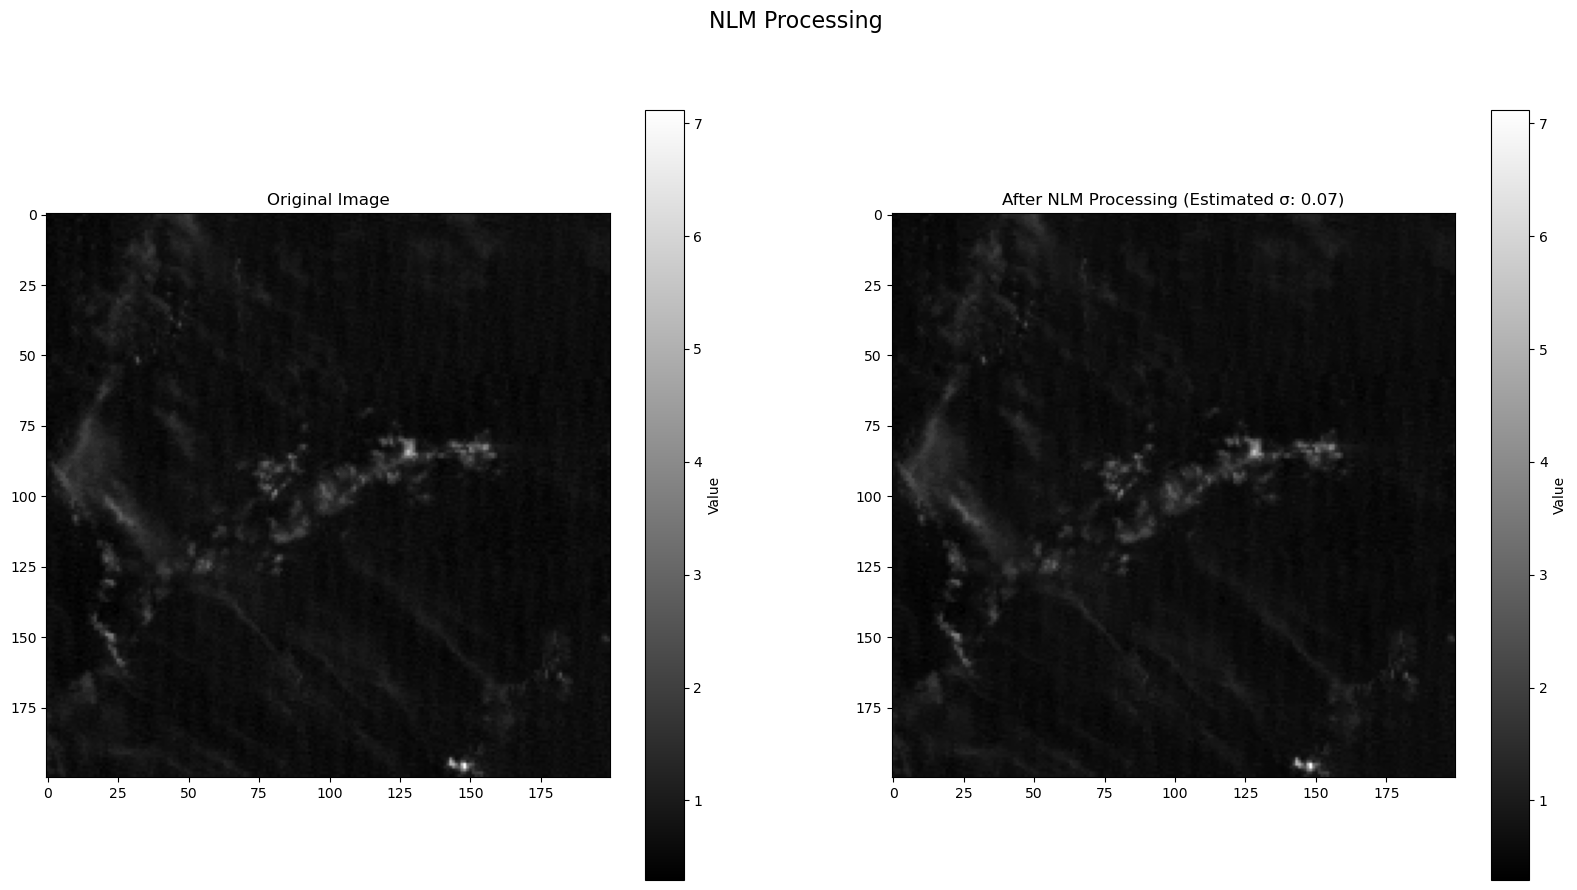

In [22]:
# 第二個單元格：NLM 處理
from skimage.restoration import estimate_sigma, denoise_nl_means
import inspect

def nlm_process(image, h):

    sigma_est = np.mean(estimate_sigma(image, channel_axis=None))
    nlm_image = denoise_nl_means(image, h=h * sigma_est, fast_mode=False, 
                                     patch_size=3, patch_distance=2, channel_axis=None)
    
    return nlm_image, sigma_est

# 測試 NLM 處理
file_path = r'C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\datas\Band03IW\MSRCLAHE\20190603_20190609\tbb-201906032130.ext.01.fld_output.txt'
raw_data = read_data(file_path)

nlm_image, sigma_est = nlm_process(raw_data, h = 0.8)
plot_comparison(raw_data, nlm_image, 'NLM Processing', sigma_est)



MSR 處理

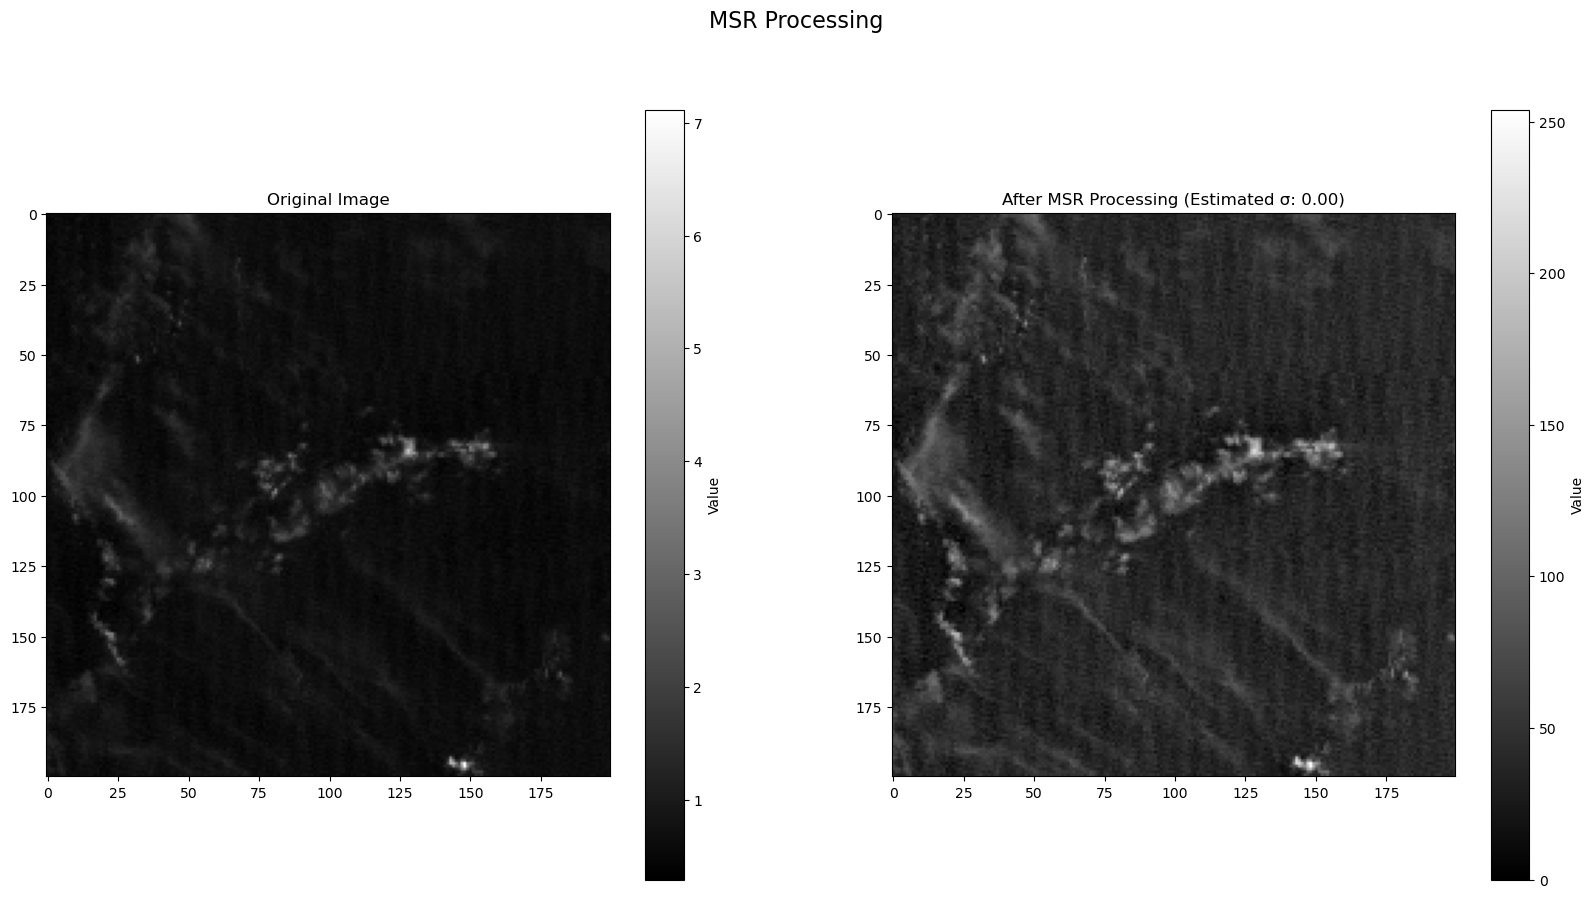

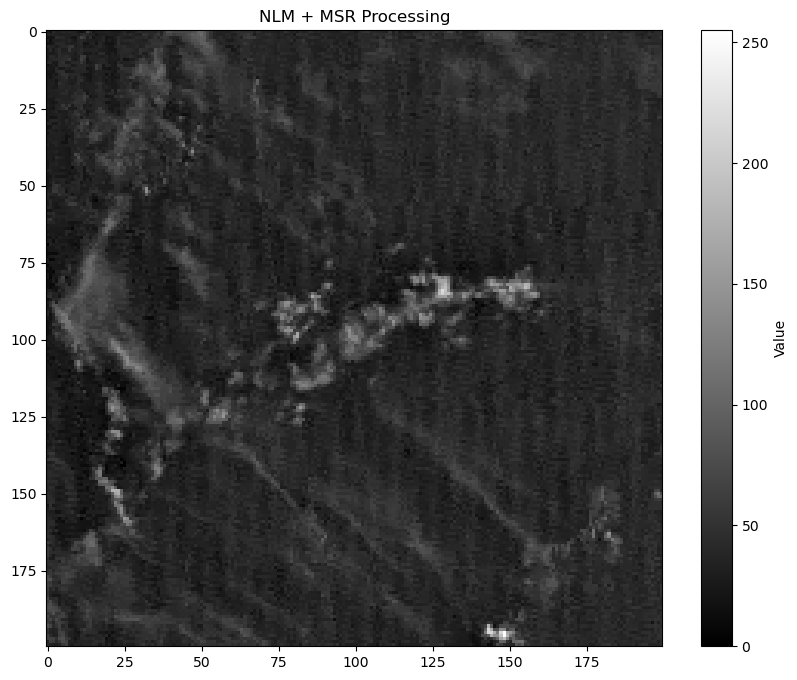

In [23]:
# 第三個單元格：MSR 處理
def msr_process(image, scales=[5, 15, 30, 60]):
    def MSR(img, scales):
        result = np.zeros_like(img, dtype=np.float32)
        for scale in scales:
            blurred = cv2.GaussianBlur(img, (0, 0), scale)
            result += np.log1p(img) - np.log1p(blurred)
        result = result / len(scales)
        return result

    msr_image = MSR(image, scales)
    msr_image = cv2.normalize(msr_image, None, 0, 255, cv2.NORM_MINMAX)
    return msr_image.astype(np.uint8)

# 測試 MSR 處理
msr_image = msr_process(raw_data)
plot_comparison(raw_data, msr_image, 'MSR Processing', 0)

# 測試 NLM + MSR 處理
nlm_msr_image = msr_process(nlm_image)

plot_image(nlm_msr_image, 'NLM + MSR Processing')

限制對比度自適應直方圖均衡（Contrast Limited Adaptive histgram equalization CLAHE)

In [24]:
# create clahe image
clahe = cv2.createCLAHE(clipLimit=8.0, tileGridSize=(2, 2))
nlm_msr_clahe= clahe.apply(nlm_msr_image)
msr_clahe = clahe.apply(msr_image)

raw_data_gray = raw_data.astype('uint8')
raw_data_clahe = clahe.apply(raw_data_gray)


# # plot image histogram 
# plt.hist(raw_data.ravel(), 256, [0, 255],label= 'original image')
# plt.hist(clahe_img2.ravel(), 256, [0, 255],label= 'clahe image')
# plt.legend()

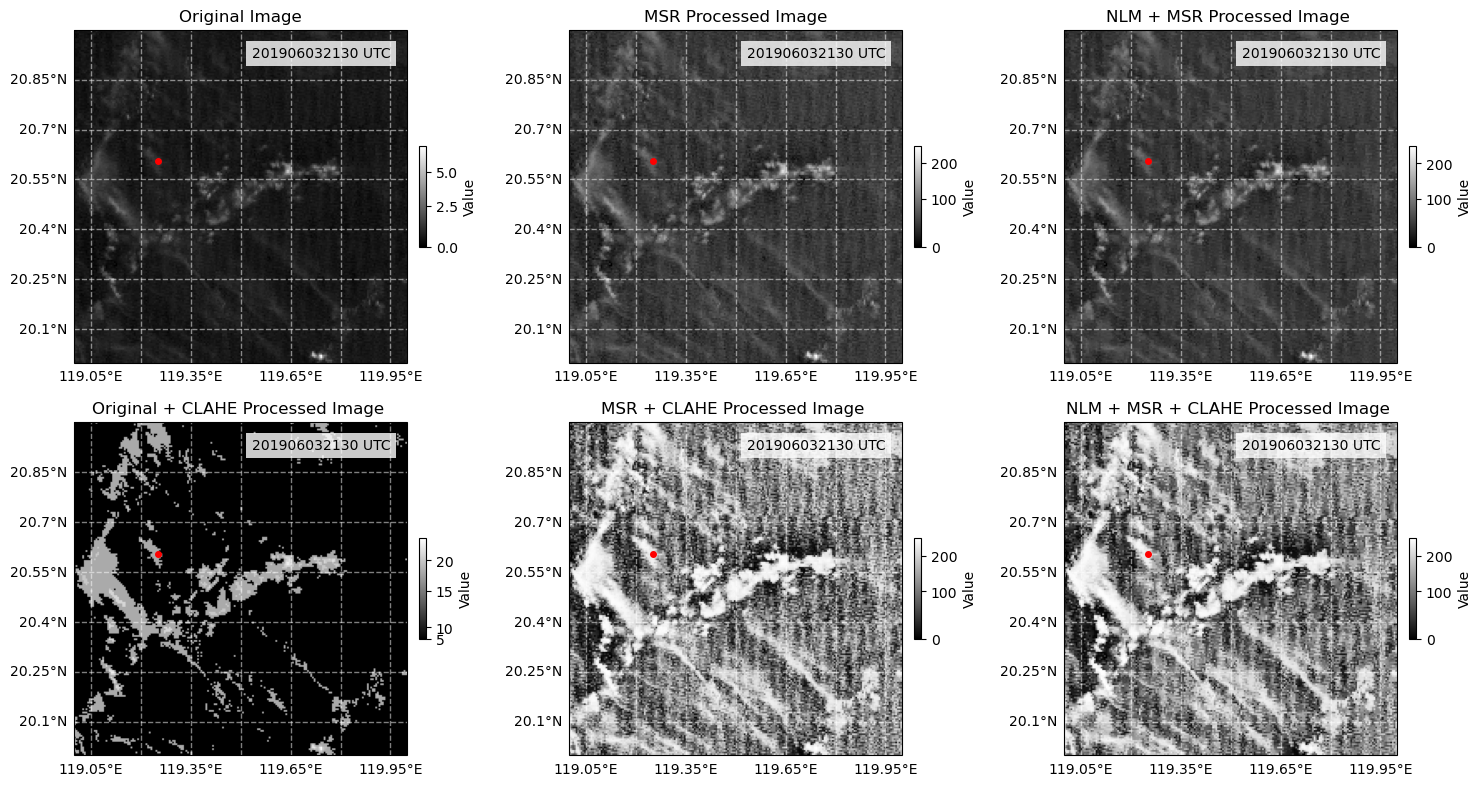

In [25]:
import re

def plot_with_geo_info(image, extent, time_info, locked_longitude, locked_latitude, title, ax):
    ax.set_extent(extent)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    img = ax.imshow(image, extent=extent, transform=ccrs.PlateCarree(), 
                    cmap='gray', norm=PowerNorm(gamma=0.8), origin='upper')
    
    cbar = plt.colorbar(img, ax=ax, orientation='vertical', pad=0.03, aspect=15, shrink=0.3)
    cbar.set_label('Value')
    
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='white', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    ax.plot(locked_longitude, locked_latitude, marker='o', color='red', markersize=4, transform=ccrs.PlateCarree())
    
    ax.text(0.95, 0.95, time_info + ' UTC', horizontalalignment='right', 
             verticalalignment='top', transform=ax.transAxes, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    ax.set_title(title)

# 測試添加地理信息的繪圖
extent = [119, 120, 20, 21]
time_info = re.search(r'\d{4}\d{2}\d{2}\d{2}\d{2}', file_path).group()
locked_longitude, locked_latitude = 119.25165, 20.60495

fig, axes = plt.subplots(2, 3, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})

plot_with_geo_info(raw_data, extent, time_info, locked_longitude, locked_latitude, 'Original Image', axes[0,0])
# plot_with_geo_info(nlm_image, extent, time_info, locked_longitude, locked_latitude, 'NLM Processed Image', axes[0, 1])
plot_with_geo_info(msr_image, extent, time_info, locked_longitude, locked_latitude, 'MSR Processed Image', axes[0, 1])
plot_with_geo_info(nlm_msr_image, extent, time_info, locked_longitude, locked_latitude, 'NLM + MSR Processed Image ', axes[0, 2])
plot_with_geo_info(raw_data_clahe, extent, time_info, locked_longitude, locked_latitude, 'Original + CLAHE Processed Image ', axes[1, 0])
plot_with_geo_info(msr_clahe, extent, time_info, locked_longitude, locked_latitude, 'MSR + CLAHE Processed Image ', axes[1, 1])
plot_with_geo_info(nlm_msr_clahe, extent, time_info, locked_longitude, locked_latitude, 'NLM + MSR + CLAHE Processed Image ', axes[1, 2])

plt.tight_layout()
plt.show()

In [26]:
# 評估原始圖像
original_metrics = evaluate_image(raw_data)

# 評估去噪後的圖像
denoised_metrics = evaluate_image(nlm_image)

# NLMMSR 處理後的評估
NLMMSR_metrics = evaluate_image(nlm_msr_image)
MSR_metrics = evaluate_image(msr_image)
raw_data_clahe_metrics = evaluate_image(raw_data_clahe)
msr_clahe_metrics = evaluate_image(msr_clahe)
nlm_msr_clahe_metrics = evaluate_image(nlm_msr_clahe)

# 打印結果
print("Original Image Metrics:")
for key, value in original_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nDenoised Image Metrics:")
for key, value in denoised_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nNLM + MSR Processed Image Metrics:")
for key, value in NLMMSR_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nraw_data_CLAHE Processed Image Metrics:")
for key, value in raw_data_clahe_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nMSR_CLAHE Processed Image Metrics:")
for key, value in msr_clahe_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nNLM_MSR_CLAHE Processed Image Metrics:")
for key, value in nlm_msr_clahe_metrics.items():
    print(f"{key}: {value:.4f}")


# 計算改進百分比
print("\nNLM改進百分比:")
for key in original_metrics.keys():
    improvement = (denoised_metrics[key] - original_metrics[key]) / original_metrics[key] * 100
    print(f"{key}: {improvement:.2f}%")


print("\nMSR 改進百分比:")
for key in original_metrics.keys():
    improvement = (MSR_metrics[key] - original_metrics[key]) / original_metrics[key] * 100
    print(f"{key}: {improvement:.2f}%")

print("\nNLM + MSR 改進百分比:")
for key in original_metrics.keys():
    improvement = (NLMMSR_metrics[key] - original_metrics[key]) / original_metrics[key] * 100
    print(f"{key}: {improvement:.2f}%")

print("\nraw_data_clahe 改進百分比:")
for key in original_metrics.keys():
    improvement = (raw_data_clahe_metrics[key] - original_metrics[key]) / original_metrics[key] * 100
    print(f"{key}: {improvement:.2f}%")

print("\nmsr_clahe 改進百分比:")
for key in original_metrics.keys():
    improvement = (msr_clahe_metrics[key] - original_metrics[key]) / original_metrics[key] * 100
    print(f"{key}: {improvement:.2f}%")

print("\nnlm_msr_clahe 改進百分比:")
for key in original_metrics.keys():
    improvement = (nlm_msr_clahe_metrics[key] - original_metrics[key]) / original_metrics[key] * 100
    print(f"{key}: {improvement:.2f}%")


Original Image Metrics:
ENL: 38.3365
Var: 0.0800
BDS: 0.3669
Relative Backscatter: 0.3780
Weighted Relative Backscatter: -0.0476

Denoised Image Metrics:
ENL: 47.3675
Var: 0.0787
BDS: 0.3712
Relative Backscatter: 0.3749
Weighted Relative Backscatter: -0.0472

NLM + MSR Processed Image Metrics:
ENL: 24.2315
Var: 260.5218
BDS: 22.6234
Relative Backscatter: 0.3741
Weighted Relative Backscatter: 0.6116

raw_data_CLAHE Processed Image Metrics:
ENL: 47.5415
Var: 8.5271
BDS: 9.1687
Relative Backscatter: 0.2907
Weighted Relative Backscatter: 0.2913

MSR_CLAHE Processed Image Metrics:
ENL: 8.6071
Var: 4541.2239
BDS: 115.0598
Relative Backscatter: 0.5447
Weighted Relative Backscatter: 1.1397

NLM_MSR_CLAHE Processed Image Metrics:
ENL: 9.6063
Var: 4399.6504
BDS: 113.0037
Relative Backscatter: 0.5412
Weighted Relative Backscatter: 1.1302

NLM改進百分比:
ENL: 23.56%
Var: -1.67%
BDS: 1.16%
Relative Backscatter: -0.82%
Weighted Relative Backscatter: -0.75%

MSR 改進百分比:
ENL: -48.58%
Var: 338118.77%
BDS: 61

評估指標

In [27]:
# 評估原始圖像
original_metrics = evaluate_image(raw_data)

# 評估去噪後的圖像
denoised_metrics = evaluate_image(nlm_image)

# NLMMSR 處理後的評估
NLMMSR_metrics = evaluate_image(nlm_msr_image)


# 打印結果
print("Original Image Metrics:")
for key, value in original_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nDenoised Image Metrics:")
for key, value in denoised_metrics.items():
    print(f"{key}: {value:.4f}")

print("\nNLM + MSR Processed Image Metrics:")
for key, value in NLMMSR_metrics.items():
    print(f"{key}: {value:.4f}")

# 計算改進百分比
print("\nNLM改進百分比:")
for key in original_metrics.keys():
    improvement = (denoised_metrics[key] - original_metrics[key]) / original_metrics[key] * 100
    print(f"{key}: {improvement:.2f}%")

print("\nNLM + MSR 改進百分比:")
for key in original_metrics.keys():
    improvement = (NLMMSR_metrics[key] - original_metrics[key]) / original_metrics[key] * 100
    print(f"{key}: {improvement:.2f}%")


Original Image Metrics:
ENL: 38.3365
Var: 0.0800
BDS: 0.3669
Relative Backscatter: 0.3780
Weighted Relative Backscatter: -0.0476

Denoised Image Metrics:
ENL: 47.3675
Var: 0.0787
BDS: 0.3712
Relative Backscatter: 0.3749
Weighted Relative Backscatter: -0.0472

NLM + MSR Processed Image Metrics:
ENL: 24.2315
Var: 260.5218
BDS: 22.6234
Relative Backscatter: 0.3741
Weighted Relative Backscatter: 0.6116

NLM改進百分比:
ENL: 23.56%
Var: -1.67%
BDS: 1.16%
Relative Backscatter: -0.82%
Weighted Relative Backscatter: -0.75%

NLM + MSR 改進百分比:
ENL: -36.79%
Var: 325450.44%
BDS: 6065.93%
Relative Backscatter: -1.03%
Weighted Relative Backscatter: -1385.80%


Edge Detection

Length: 629.17
Length: 434.62
Length: 256.69
Length: 418.27
Length: 227.14


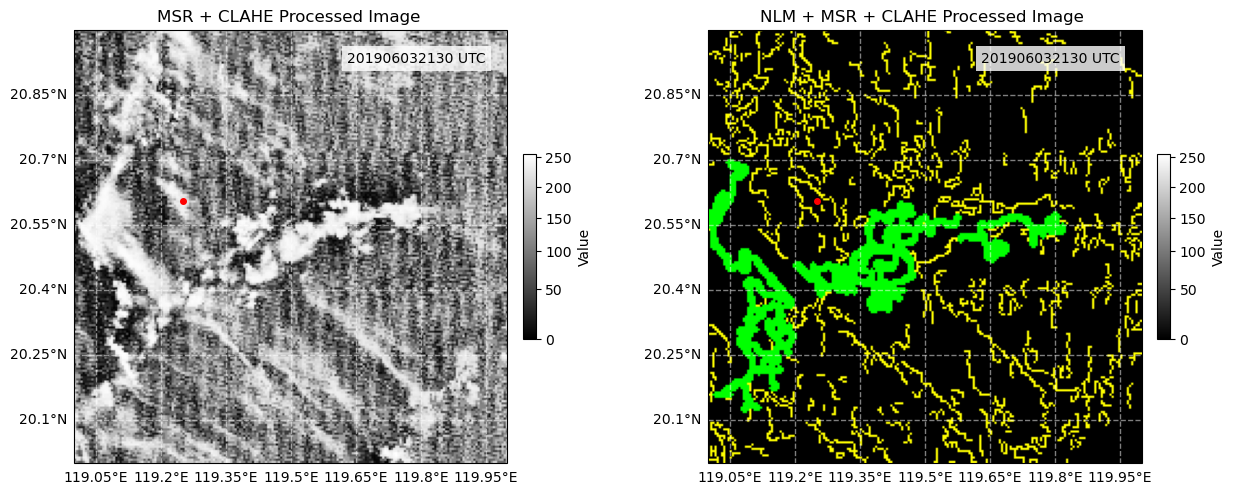

In [28]:
# 應用 Canny 邊緣偵測
edges = cv2.Canny(nlm_msr_clahe, 300, 500, L2gradient=True)

# 找到輪廓
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
color_edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
color_edges[edges != 0] = [255, 255, 0] # 黃色

#計算每個輪廓的周長並在圖像繪製
for contour in contours:
    length = cv2.arcLength(contour, closed=True)
    if length > 200 :
        cv2.drawContours(color_edges, [contour], -1, (0, 255, 0), 2)
        print(f"Length: {length:.2f}")

# 測試添加地理信息的繪圖
extent = [119, 120, 20, 21]
time_info = re.search(r'\d{4}\d{2}\d{2}\d{2}\d{2}', file_path).group()
locked_longitude, locked_latitude = 119.25165, 20.60495

fig1, axes1 = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_with_geo_info(msr_clahe, extent, time_info, locked_longitude, locked_latitude, 'MSR + CLAHE Processed Image ', axes1[0])
plot_with_geo_info(color_edges, extent, time_info, locked_longitude, locked_latitude, 'NLM + MSR + CLAHE Processed Image ', axes1[1])


判斷邊緣角度

c:\Users\Alan\anaconda3\envs\research\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from current font.
  super()._update_title_position(renderer)
c:\Users\Alan\anaconda3\envs\research\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from current font.
  super()._update_title_position(renderer)
c:\Users\Alan\anaconda3\envs\research\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 37002 (\N{CJK UNIFIED IDEOGRAPH-908A}) missing from current font.
  super()._update_title_position(renderer)
c:\Users\Alan\anaconda3\envs\research\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 32227 (\N{CJK UNIFIED IDEOGRAPH-7DE3}) missing from current font.
  super()._update_title_position(renderer)
c:\Users\Alan\anaconda3\envs\research\lib\site-packages\cartopy\mpl\geoaxes.py:538: UserWarning: Glyph 36942 (\N{CJK UNIFIED IDEOGRAPH-904E}) missing fr

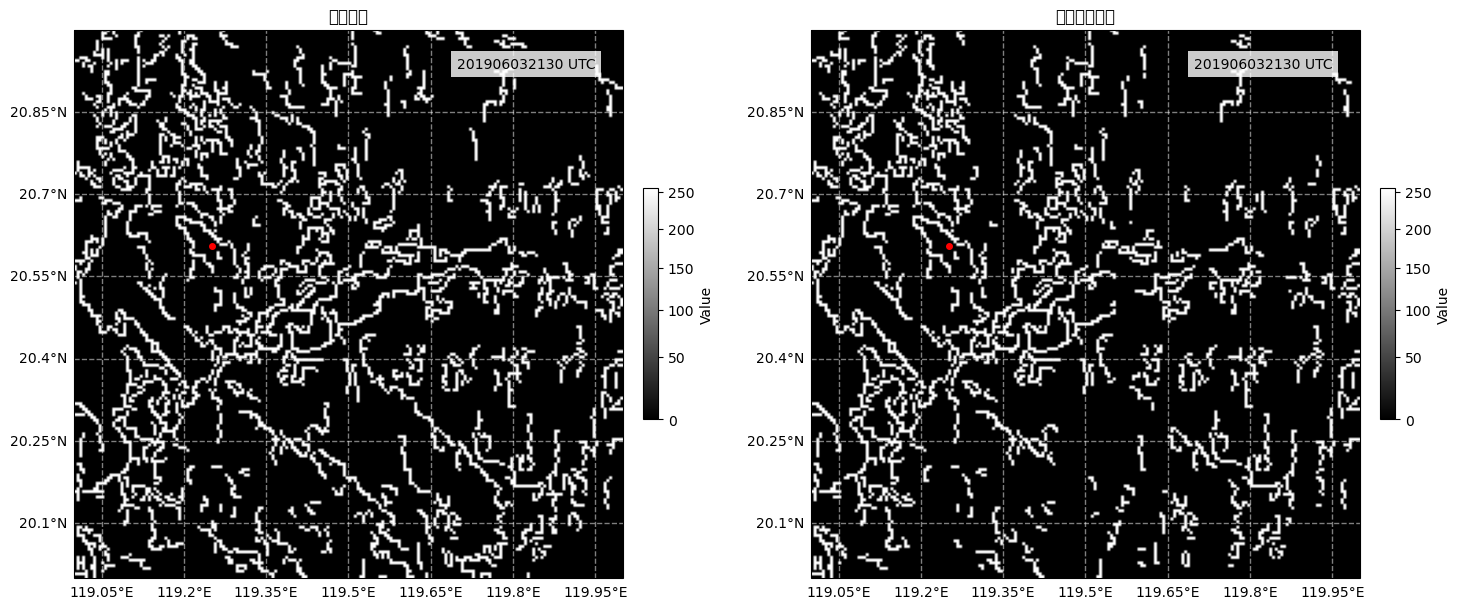

Length: 600.85
Length: 131.40
Length: 418.72
Length: 100.57
Length: 416.86
Length: 138.78
Length: 190.51
Length: 114.57
Length: 125.88
Length: 165.68


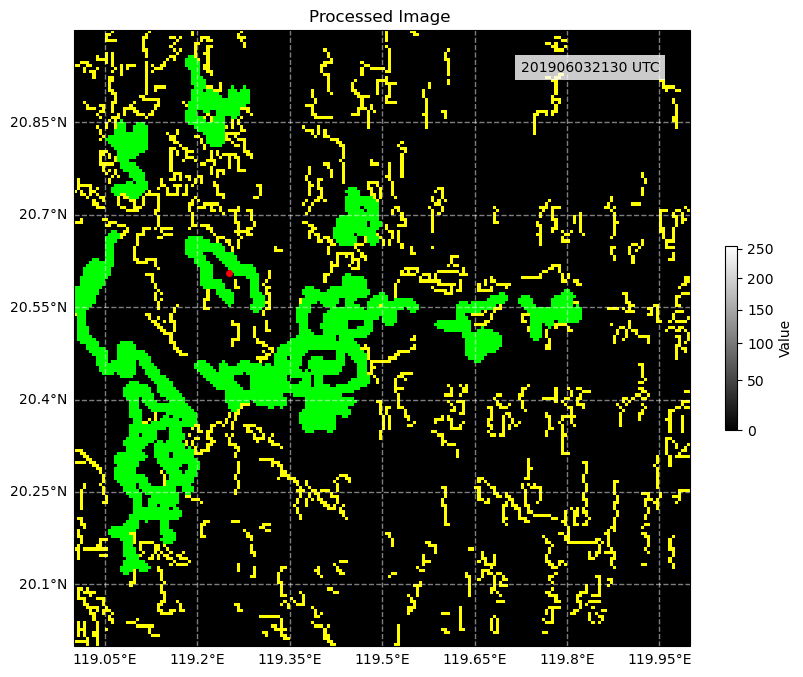

In [29]:
import cv2
import numpy as np

def filter_edges_by_angle(edges, min_angle=85, max_angle=110):
    # 調整 HoughLinesP 參數
    lines = cv2.HoughLinesP(edges, 0.5, np.pi/180, threshold=10, minLineLength=30, maxLineGap=30)
    
    mask = np.zeros_like(edges)
    
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.abs(np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi)
            
            if min_angle <= angle <= max_angle or min_angle <= (180 - angle) <= max_angle:
                cv2.line(mask, (x1, y1), (x2, y2), 255, 2)
    
    # 應用形態學操作
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)
    mask = cv2.erode(mask, kernel, iterations=1)
    
    filtered_edges = cv2.bitwise_and(edges, mask)
    return filtered_edges

# 使用示例
filtered_edges = filter_edges_by_angle(edges)

# 顯示結果
fig, axes = plt.subplots(1, 2, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_with_geo_info(edges, extent, time_info, locked_longitude, locked_latitude, '原始邊緣', axes[0])
plot_with_geo_info(filtered_edges, extent, time_info, locked_longitude, locked_latitude, '過濾後的邊緣', axes[1])

plt.tight_layout()
plt.show()

# 找到輪廓
contours, _ = cv2.findContours(filtered_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
color_edges = cv2.cvtColor(filtered_edges, cv2.COLOR_GRAY2BGR)
color_edges[filtered_edges != 0] = [255, 255, 0]

# 計算每個輪廓的周長並在圖像繪製
for contour in contours:
    length = cv2.arcLength(contour, closed=False)
    if length > 100:
        cv2.drawContours(color_edges, [contour], -1, (0, 255, 0), 2)
        print(f"Length: {length:.2f}")

# 測試添加地理信息的繪圖
fig1, axes1 = plt.subplots(1, 1, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_with_geo_info(color_edges, extent, time_info, locked_longitude, locked_latitude, 'Processed Image ', axes1)

讀取Band03 與 Band06圖片

In [30]:
def load_image(file_path):
    image = np.loadtxt(file_path)
    return image

def resize_image(image, target_shape):
    resized_image = cv2.resize(image, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)
    return resized_image

def normalize_image(image):
    # Normalize the image to 0-1 range
    min_val = np.min(image)
    max_val = np.max(image)
    normalized = (image - min_val) / (max_val - min_val)
    return normalized

def calculate_difference(image1, image2):
    # Compute the absolute difference between the two normalized images
    difference = np.abs(image1.astype(np.float32) - image2.astype(np.float32))
    return difference

# Configure parameters
BASE_PATH = r'C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\datas'
BAND03_PATH = os.path.join(BASE_PATH, 'Band03txt', '20190617_20190618', 'tbb-201906180710.ext.01.fld_output.txt')
BAND06_PATH = os.path.join(BASE_PATH, 'Band06txt', 'tbb-201906180710.sir.02.fld_output.txt')
OUTPUT_PATH = os.path.join(BASE_PATH, 'test', '20190617_20190618', 'difference_image.png')

# Load images
try:
    band03_image = load_image(BAND03_PATH)
    band06_image = load_image(BAND06_PATH)
except FileNotFoundError as e:
    print(f"Error: Unable to find file - {e}")
    exit(1)
except Exception as e:
    print(f"Error: Issue loading images - {e}")
    exit(1)

print(band03_image.shape)
print(band06_image.shape)


# Resize Band 06 image to match Band 03 image resolution
target_shape = (band03_image.shape[0], band03_image.shape[1])  # Match Band 03 resolution
band06_resized = resize_image(band06_image, target_shape)
print(band06_resized.shape)

# 載入和調整圖像大小的部分保持不變

# 繪製原始圖像和直方圖
plt.figure(figsize=(15, 10))

# 繪製 Band 03 圖像
plt.subplot(2, 2, 1)
plt.imshow(band03_image, cmap='gray')
plt.title('Original Band 03 Image')
plt.colorbar()
plt.axis('off')

# 繪製 Band 03 直方圖
plt.subplot(2, 2, 2)
plt.hist(band03_image.flatten(), bins=256, range=(np.min(band03_image), np.max(band03_image)), color='black')
plt.title('Histogram of Original Band 03 Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)

# 繪製 Band 06 圖像
plt.subplot(2, 2, 3)
plt.imshow(band06_resized, cmap='gray')
plt.title('Original Band 06 Image')
plt.colorbar()
plt.axis('off')

# 繪製 Band 06 直方圖
plt.subplot(2, 2, 4)
plt.hist(band06_resized.flatten(), bins=256, range=(np.min(band06_resized), np.max(band06_resized)), color='black')
plt.title('Histogram of Original Band 06 Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

# 正規化圖像
band03_normalized = normalize_image(band03_image)
band06_normalized = normalize_image(band06_resized)

# 繪製正規化後的圖像和直方圖
plt.figure(figsize=(15, 10))

# 繪製正規化後的 Band 03 圖像
plt.subplot(2, 2, 1)
plt.imshow(band03_normalized, cmap='gray')
plt.title('Normalized Band 03 Image')
plt.colorbar()
plt.axis('off')

# 繪製正規化後的 Band 03 直方圖
plt.subplot(2, 2, 2)
plt.hist(band03_normalized.flatten(), bins=256, range=(0, 1), color='black')
plt.title('Histogram of Normalized Band 03 Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)

# 繪製正規化後的 Band 06 圖像
plt.subplot(2, 2, 3)
plt.imshow(band06_normalized, cmap='gray')
plt.title('Normalized Band 06 Image')
plt.colorbar()
plt.axis('off')

# 繪製正規化後的 Band 06 直方圖
plt.subplot(2, 2, 4)
plt.hist(band06_normalized.flatten(), bins=256, range=(0, 1), color='black')
plt.title('Histogram of Normalized Band 06 Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

# 計算差異圖像
difference_image = calculate_difference(band06_normalized, band03_normalized)

# 繪製差異圖像與直方圖
plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 1)
plt.title('Difference Image (|Band06 - Band03|)')
plt.imshow(difference_image, cmap='coolwarm', vmin=0, vmax=np.max(difference_image))
plt.colorbar()
plt.axis('off')


plt.subplot(2, 2, 2)
plt.hist(difference_image.flatten(), bins=256, range=(0, np.max(difference_image)), color='black')
plt.title('Histogram of Absolute Difference Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Error: Unable to find file - C:\Users\Alan\Dropbox\Himawari8_Wave_Speed_Detection\datas\Band03txt\20190617_20190618\tbb-201906180710.ext.01.fld_output.txt not found.


NameError: name 'band03_image' is not defined

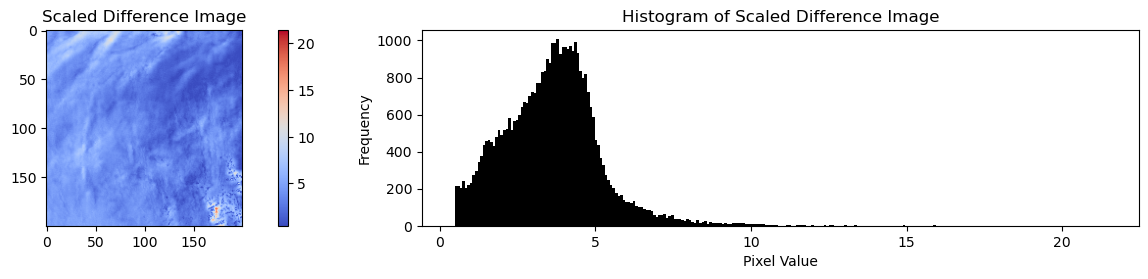

In [ ]:
band03_min = np.min(band03_image)
band03_max = np.max(band03_image)
band06_min = np.min(band06_resized)
band06_max = np.max(band06_resized)

overall_min = min(band03_min, band06_min)
overall_max = max(band03_max, band06_max)

# Calculate the difference between the normalized images
difference_image_resized = calculate_difference(band06_normalized, band03_normalized)

# Scale the difference back to the original range
difference_image_scaled = difference_image_resized * (overall_max - overall_min) + overall_min


plt.figure(figsize=(15, 5))

plt.subplot(2, 2, 1)
plt.imshow(difference_image_scaled, cmap='coolwarm', vmin=overall_min, vmax=overall_max)
plt.title('Scaled Difference Image')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.hist(difference_image_scaled.flatten(), bins=256, range=(overall_min, overall_max), color='black')
plt.title('Histogram of Scaled Difference Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()